The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description.

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd

# Data Visualisation
import seaborn as sns

In [2]:
# Load Data
train_data = pd.read_csv('train_data2.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
# data shape
train_data.shape, test_data.shape

((10000, 3), (7600, 3))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class Index', ylabel='count'>

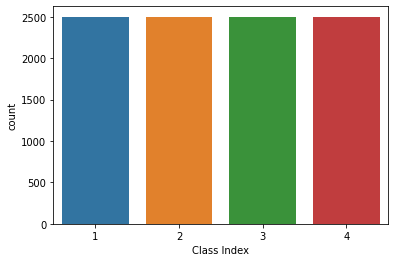

In [5]:
# checking the length each class index in train data
sns.countplot(train_data['Class Index'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class Index', ylabel='count'>

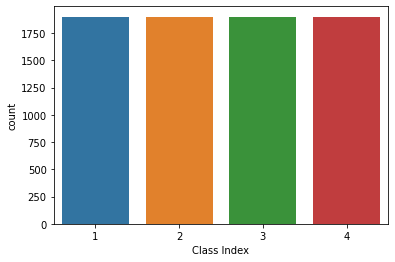

In [6]:
# checking the length each class index in test data
sns.countplot(test_data['Class Index'])

In [7]:
# checking for null values in train data
train_data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [8]:
# checking for null values in test data
test_data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

From the above analysis the data has no abnormalities or imbalance.

### Text Processing

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
# Combine Title and Description
x_train = train_data['Title']+ ' ' + train_data['Description'] # combining the title and description
y_train = train_data['Class Index'].apply(lambda x:(x-1)).values # Class labels need to begin from 0

x_test = test_data['Title']+ ' ' + test_data['Description']
y_test = test_data['Class Index'].apply(lambda x: (x-1)).values

In [11]:
x_train[0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [12]:
# function to preprocess text by removing puntuation, stopwords and also lemmatizing and tokenise the text
def preprocess(text):
    tokenizer = nltk.RegexpTokenizer(r'\w+') 
    wnl = WordNetLemmatizer()              
    article = tokenizer.tokenize(text)          # tokenize and removes punctuation
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    article = [wnl.lemmatize(word) for word in article if not word in set(stop_words)]
    # removes stopwords and lemmatize the text
    return ' '.join(article)

In [13]:
xtrain = x_train.apply(lambda x:preprocess(x))
xtest = x_test.apply(lambda x:preprocess(x))

In [14]:
xtrain[10]      # checking the processed text

'Oil Economy Cloud Stocks Outlook NEW YORK Reuters Soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums'

In [15]:
xtest[10]

'Group Propose New High Speed Wireless Format LOS ANGELES Reuters A group technology company including Texas Instruments Inc lt TXN N gt STMicroelectronics lt STM PA gt Broadcom Corp lt BRCM O gt Thursday said propose new wireless networking standard 10 time speed current generation'

### Model buliding

In [16]:
#pip install -q transformers

In [17]:
# train and validation split
from sklearn.model_selection import train_test_split

X = list(xtrain)
Y = y_train
xtest = list(xtest)
ytest = y_test

x_val, x_test, y_val, y_test = train_test_split(xtest, ytest, test_size = 0.5)

In [18]:
print(len(X),len(Y),len(x_val),len(y_val),len(x_test),len(y_test))

10000 10000 3800 3800 3800 3800


In [19]:
from transformers import DistilBertTokenizerFast, TFDistilBertModel
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = TFDistilBertModel.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [20]:
#Max Length of sentences in Train Dataset
max_words = 128

# tokenise
X_train_tokenized = tokenizer(X, padding=True, truncation=True, max_length=max_words, return_tensors = "tf")
X_val_tokenized = tokenizer(x_val, padding=True, truncation=True, max_length=max_words, return_tensors = "tf")
X_test_tokenized = tokenizer(x_test, padding='max_length', truncation=True, max_length=max_words, return_tensors = "tf")

In [21]:
len(X_train_tokenized['input_ids'][1]),len(X_val_tokenized['input_ids'][1]),len(X_test_tokenized['input_ids'][1])

(128, 128, 128)

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal 
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.keras.metrics import CategoricalAccuracy 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [23]:
max_len = 128

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len, ), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = model(input_ids, attention_mask= input_mask)[0] #(0 is the last hidden states, 1 means pooler_output) 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)

y = Dense(4, activation = 'sigmoid')(out)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

### Training the model

In [25]:
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

In [26]:
train_history = model.fit(
    x = {'input_ids' :X_train_tokenized['input_ids'], 'attention_mask' :X_train_tokenized['attention_mask']},
    y = to_categorical(y_train),
    validation_data = ({'input_ids' :X_val_tokenized['input_ids'], 'attention_mask' :X_val_tokenized['attention_mask']}, to_categorical(y_val)),
    epochs=5)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 178s 483ms/step - loss: 0.4098 - balanced_accuracy: 0.8589 - val_loss: 0.2913 - val_balanced_accuracy: 0.8989
Epoch 2/5
313/313 [==============================] - 142s 455ms/step - loss: 0.2232 - balanced_accuracy: 0.9278 - val_loss: 0.3285 - val_balanced_accuracy: 0.8955
Epoch 3/5
313/313 [==============================] - 146s 466ms/step - loss: 0.1317 - balanced_accuracy: 0.9569 - val_loss: 0.3303 - val_balanced_accuracy: 0.8979
Epoch 4/5
313/313 [==============================] - 145s 464ms/step - loss: 0.0826 - balanced_accuracy: 0.9739 - val_loss: 0.3620 - val_balanced_accuracy: 0.9018
Epoch 5/5
313/313 [==============================] - 145s 465ms/step - loss: 0.0593 - balanced_accuracy: 0.9810 - val_loss: 0.4290 - val_balanced_accuracy: 0.8918


### Testing the model

In [27]:
pred = model.predict({'input_ids' :X_test_tokenized['input_ids'], 'attention_mask' :X_test_tokenized['attention_mask']})
y_pred = np.argmax(pred, axis=1)

119/119 [==============================] - 17s 133ms/step


### Performance metrics

In [28]:
from sklearn.metrics import classification_report
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       932
           1       0.96      0.96      0.96       953
           2       0.93      0.77      0.84       968
           3       0.79      0.95      0.86       947

    accuracy                           0.89      3800
   macro avg       0.90      0.89      0.89      3800
weighted avg       0.90      0.89      0.89      3800



### Testing on samples

In [29]:
class_labels = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Tech"}

In [45]:
text = ''' What a match! It's pleasure to the eye. Even though my team lost.'''
text = preprocess(text)
text = tokenizer(text=text, padding="max_length", truncation=True, max_length=128, return_tensors='tf') 
predicted = model.predict({'input_ids' : text['input_ids'], 'attention_mask' : text['attention_mask']})*100
pred = np.argmax(predicted, axis=1)
class_labels[pred[0]]

1/1 [==============================] - 0s 124ms/step


'Sports'